# A guide to using the HoloFood Data Portal
This tutorial showcases the core uses of the Data Portal.
There is a solution to each learning objective.

## Objective 1: Finding samples using the website

Open the [HoloFood Data Portal]({{< var portal.root_url >}}).

Find all *Salmon* samples from the project `PRJEB41657`.

:::{.callout-tip collapse="true"}
## Solution
Type `PRJEB41657` into the `Project accession contains` filter next to the table, and press `Apply`.
:::

## Objective 2: Find metadata for a specific sample

- Find the *Chicken* sample `SAMEA7025251`.
- From the sample's metadata, find the average daily feed intake of chicken's in that pen in the first trial week.

:::{.callout-tip collapse="true"}
## Solution

- Click `Chicken samples` in the navigation bar.
- Type `SAMEA7025251` into the `Accession contains` filter, press `Apply`.
- Click `View` in the single row of the table.
- Open the `Sample metadata` section of the sample detail page.
- Switch to the `Pen` tab of metadata.
- Find the `Average Daily Feed intake: Day 00 - 07` row (measurement = 18.59g).
:::

## Objective 3: Find MAG metadata from MGnify

:::{.callout-caution}
## Fake data
Currently this example is based on fake data that does not originate from the HoloFood project.
:::

- Find the `HoloFood Cow Rumen v1` genome `MGYG1`
- Using the genome's species representative, find the genome's most prevalent [COG category](https://www.ncbi.nlm.nih.gov/research/cog) with a known function.

:::{.callout-tip collapse="true"}
## Solution

- Click `Genomes` in the navigation bar.
- Select the `HoloFood Cow Rumen v1` catalogue in the sub navigation
- Type `MGYG1` in the `Accession contains` filter.
- Click `View on MGnify` in the single row of the table.
- On the MGnify page that opens, switch to the `COG analysis` sub-tab.
- Look at the bar chart. Ignoring cataegory `S (Function unknown)`, category `M (Cell wall/membrane/envelope biogenesis)` is the most prevalent COG category in this genome.
:::

## Objective 4: Find viral fragments within a MAG

:::{.callout-caution}
## Fake data
Currently this example is based on fake data that does not originate from the HoloFood project.
:::

- Find the `HoloFood Cow Rumen Viruses v0` catalogue`
- Find a viral sequence present in the host MAG with taxonomy `Prevotella sp902792635`
- Find all of the [ViPhOG](https://osf.io/2zd9r/) viral annotations on that viral sequence

:::{.callout-tip collapse="true"}
## Solution

- Click `Viruses` in the navigation bar.
- Select the `HoloFood Cow Rumen Viruses v0` catalogue in the sub navigation
- Type `Prevotella sp902792635` in the `Host MAG taxonomy contains` filter.
- Click `View contig` in the first/only row of the table.
- In the contig viewer now shown above the table, find the `ViPhOGs` annotation track
- Click on each ViPhOG annotation (dark green), and find the `ViPhOG ID` from the popup
- You should have found two: `[ViPhOG1, ViPhOG2]`
:::

## Objective 5: Use Python to analyse data from the API

:::{.callout-tip}
## Packages required
```bash
pip install requests pandas matplotlib
```
:::

- Use the [API]({{< var portal.root_url >}}/api) to fetch a list of HoloFood samples as a Pandas dataframe (the [API docs will be very helpful](api.ipynb#from-python))
    - Only fetch samples from project `PRJEB41657`
    - Only fetch samples from Trial A Tank 1 (which happen to have sample titles starting `SA01`)
    - Only fetch samples which have a non-empty value for metadata variable `host length` (that's the length of the fish the sample came from)
- Make two histograms, showing the distribution of `host length` metadata values at timepoints `0 days` and `60 days`

In [1]:
#|include: false
samples_endpoint_base = 'http://127.0.0.1:8000/api/samples'

import requests
import pandas as pd
import matplotlib.pyplot as plt

Here's a startpoint for the libraries and base API endpoint you need:

```python
samples_endpoint_base = '{{< var portal.root_url >}}/api/samples'
import requests
import pandas as pd
import matplotlib as plt
```

A complete solution is below.

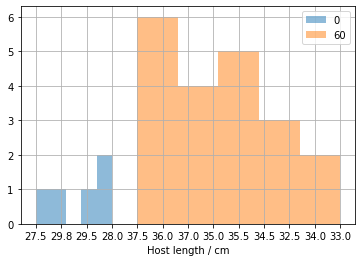

In [4]:
#|code-fold: true
page = 1

while page:
    samples_page = requests.get(
        f'{samples_endpoint_base}?{page=}&project=PRJEB41657&title=SA01&require_metadata_value=host length'
    ).json()
    samples_page_df = pd.json_normalize(
        samples_page['items']
    )
    
    if page == 1:
        samples_df = samples_page_df
    else:
        samples_df = pd.concat(
            [
                samples_df,
                samples_page_df
            ]
        )
    
    page += 1
    if len(samples_df) >= samples_page['count']:
        page = False

def get_host_length_and_timepoint(sample):
    sample_detail = requests.get(
        f'{samples_endpoint_base}/{sample.accession}'
    ).json()
    metadata = sample_detail['structured_metadata']
    host_length = next(
        metadatum 
        for metadatum in metadata 
        if metadatum['marker']['name'] == 'host length'
    )
    timepoint = next(
        metadatum 
        for metadatum in metadata 
        if metadatum['marker']['name'] == 'trial timepoint'
    )
    return host_length['measurement'], timepoint['measurement']

metadata = samples_df.apply(
    get_host_length_and_timepoint, 
    axis='columns', 
    result_type='expand'
).rename(
    columns={
        0: 'host_length_cm', 
        1: 'trial_timepoint_days'
    }
)
trial_samples = pd.concat(
    [
        samples_df,
        metadata
    ]
)
trial_samples.groupby('trial_timepoint_days').host_length_cm.hist(legend=True, bins=5, alpha=0.5)
plt.xlabel('Host length / cm');